In [1]:
# Imports
import sys
from pathlib import Path

import cv2
from IPython.display import Image, clear_output, display
from picamera2 import Picamera2
from ultralytics import YOLO

In [2]:
# Find pyproject.toml in parent directories and add its directory to sys.path
path_curr = Path.cwd()
for parent in [path_curr] + list(path_curr.parents):
    pyproject_file = parent / "pyproject.toml"
    if pyproject_file.exists():
        sys.path.insert(0, str(parent))
        break

In [3]:
# Load a pre-trained YOLO model (e.g., YOLOv8s for small, yolov8n for nano)
model = YOLO("yolo12n_ncnn_model")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [4]:
# 1. Initialize Picamera2
picam2 = Picamera2()
picam2.start()

[0:05:55.910823119] [2240]  INFO Camera camera_manager.cpp:340 libcamera v0.6.0+rpt20251202
[0:05:56.032351535] [2326]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/vc4/ov5647.json
[0:05:56.054303023] [2326]  INFO Camera camera_manager.cpp:223 Adding camera '/base/soc/i2c0mux/i2c@1/ov5647@36' for pipeline handler rpi/vc4
[0:05:56.054372041] [2326]  INFO RPI vc4.cpp:445 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media0 and ISP device /dev/media1
[0:05:56.054431764] [2326]  INFO RPI pipeline_base.cpp:1111 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:05:56.138242563] [2240]  INFO Camera camera.cpp:1215 configuring streams: (0) 640x480-XBGR8888/sRGB (1) 640x480-SGBRG10_CSI2P/RAW
[0:05:56.153613006] [2326]  INFO RPI vc4.cpp:620 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10/RAW - Selected unicam format: 640x480-pGAA/RAW


In [5]:
# 2. Modified capture and predict function
def capture_and_predict_picamera(picam2):
    # Capture frame as a NumPy array (RGB by default)
    frame = picam2.capture_array()

    if frame is None:
        print("No frame captured.")
        return

    # YOLO models usually expect BGR if using OpenCV-style processing,
    # but ultralytics can handle RGB arrays directly.
    # If results look 'blue', convert: frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # Perform object detection
    results = model.predict(frame, imgsz=320)

    # Handle results and annotate
    res = results[0] if isinstance(results, (list, tuple)) else results
    annotated_bgr = res.plot()

    # Display in Jupyter Notebook
    ok, buf = cv2.imencode(".jpg", annotated_bgr)
    if ok:
        clear_output(wait=True)
        display(Image(data=buf.tobytes()))

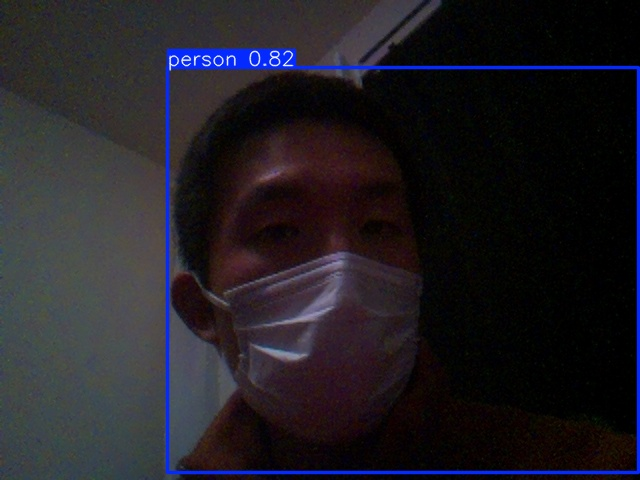

Stopped.


In [ ]:
# Example loop to run predictions
try:
    while True:
        capture_and_predict_picamera(picam2)
except KeyboardInterrupt:
    print("Stopped.")                                

In [ ]:
picam2.stop()